In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

train = pd.read_csv("/kaggle/input/titanic/train.csv")

# Fill Null Values
train["Fare"].fillna(train["Fare"].median(), inplace = True)
train["Embarked"].fillna(train["Embarked"].mode(), inplace = True)
age_avg, age_std = train["Age"].mean(), train["Age"].std()
random_values = np.random.normal(age_avg, age_std, size=len(train))
train["Age"].fillna(pd.Series(random_values), inplace=True)
train["Age"] = np.ceil(train["Age"]).astype(int)

# Create FamSize and IsAlone variables
train["FamSize"] = train["SibSp"] + train["Parch"] + 1
train["IsAlone"] = 0
train.loc[train["FamSize"] == 1, "IsAlone"] = 1
    
# Categorise "continuous" variables
train["CatAge"] = pd.cut(train["Age"], bins=pd.cut(train["Age"], bins=5).cat.categories).cat.codes
train["CatFare"] = pd.cut(train["Fare"], bins=pd.qcut(train["Fare"], q=5).cat.categories).cat.codes
train["CatFare"] = train["CatFare"].replace(-1, 4) # few rounding errors with cut function
   
# For Sex use Label Encoding
train["Sex_Code"] = train["Sex"].map({"female": 0, "male": 1})

# For Embarked use One Hot Encoding
train[["Embarked_C", "Embarked_Q", "Embarked_S"]] = pd.get_dummies(train["Embarked"]).astype(int)

In [ ]:
x_var = ["Pclass", "SibSp", "FamSize", "IsAlone", "Parch", "CatAge", "CatFare",
         "Sex_Code", "Embarked_C", "Embarked_Q", "Embarked_S"]

y_var = ["Survived"]

train[x_var + y_var]

In [3]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

model = DecisionTreeClassifier(random_state = 0)
#model = XGBClassifier(seed=0)

X = train[x_var]
y = train[y_var]

In [ ]:
def plot_feature_importances(feat, feat_import):
    """Plot feature importance scores against features"""
    df = pd.DataFrame({"Features": feat, "Importances": feat_import})
    plt.figure(figsize=(15, 6))
    sns.barplot(x="Importances", y="Features", data = df.sort_values("Importances", ascending=False))

    plt.xlabel("")
    plt.ylabel("")
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)
    plt.title(f"Ranking of the {len(feat)} best features", size=15)

    plt.show()

<a id="9"></a>
# Correlated Features

Whether RFECV removes highly correlated features or not is dependent on how the model factors in correlation to its feature importances calculations. For example, Decision Trees have an inbuilt feature selection property so that if two features are exact duplicates, only one will have a non zero feature importance **for each split**. This means even if a feature is a good predictor for the target variable, its feature importance can be low if a correlated variable is providing similar information to the model.

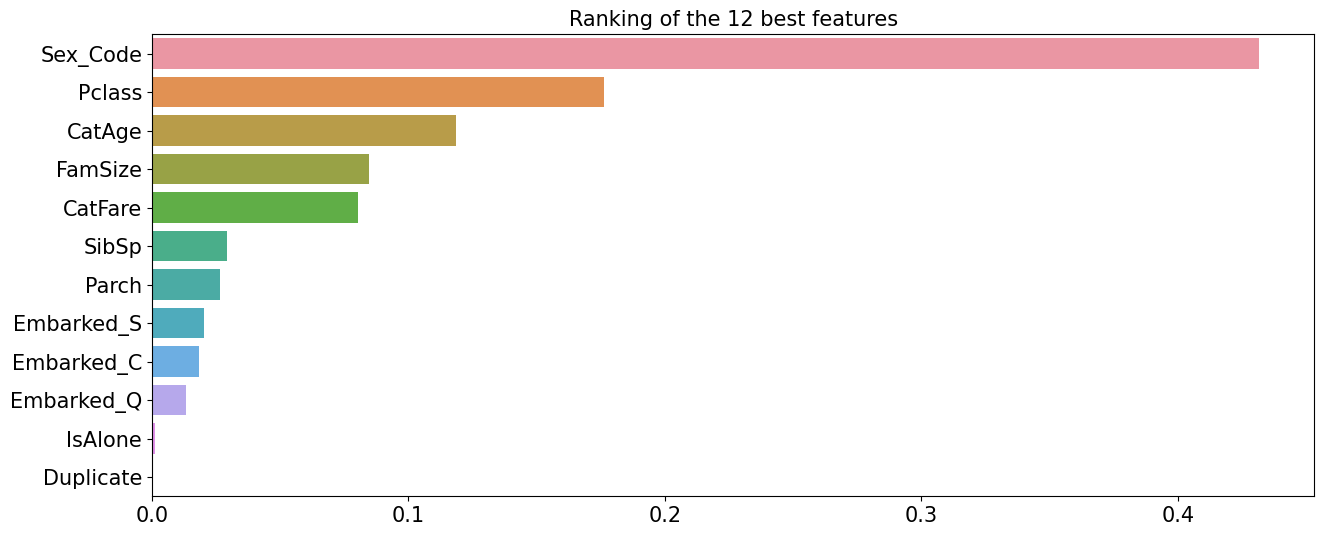

['Pclass', 'FamSize', 'CatAge', 'CatFare', 'Sex_Code']
Score: 0.8035339903333124


In [30]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

cv_split = StratifiedKFold(5, shuffle=True, random_state=0)

X_with_dup = X.copy()
X_with_dup["Duplicate"] = X_with_dup["Sex_Code"]

model.fit(X_with_dup, y)
plot_feature_importances(X_with_dup.columns, model.feature_importances_)

rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv_split,
    scoring="accuracy",
    n_jobs=-1,
)

rfecv.fit(X_with_dup, y)

print(list(rfecv.get_feature_names_out()))
print(f'Score: {np.max(rfecv.cv_results_["mean_test_score"])}')

Note that the feature importance is only completely shifted to one feature because Sex_Code has only a singular split at the root node. Generally for duplicate features, this will not be the case as the model will randomly select one of the duplicate features at every split. This is highlighted in the docstring for the random_state parameter:

>**random_state : *int, RandomState instance or None, default=None*** </br>
> Controls the randomness of the estimator. The features are always randomly permuted at each split, even if splitter is set to "best". When max_features < n_features, the algorithm will select max_features at random at each split before finding the best split among them. **But the best found split may vary across different runs, even if max_features=n_features. That is the case, if the improvement of the criterion is identical for several splits and one split has to be selected at random.**

If you duplicate a feature such as Fare which has many splits, then its duplicate feature is chosen approximately half the time and the importance tends to an equally distributed 50/50. In this case, RFECV may not remove this unnecessary duplicate.

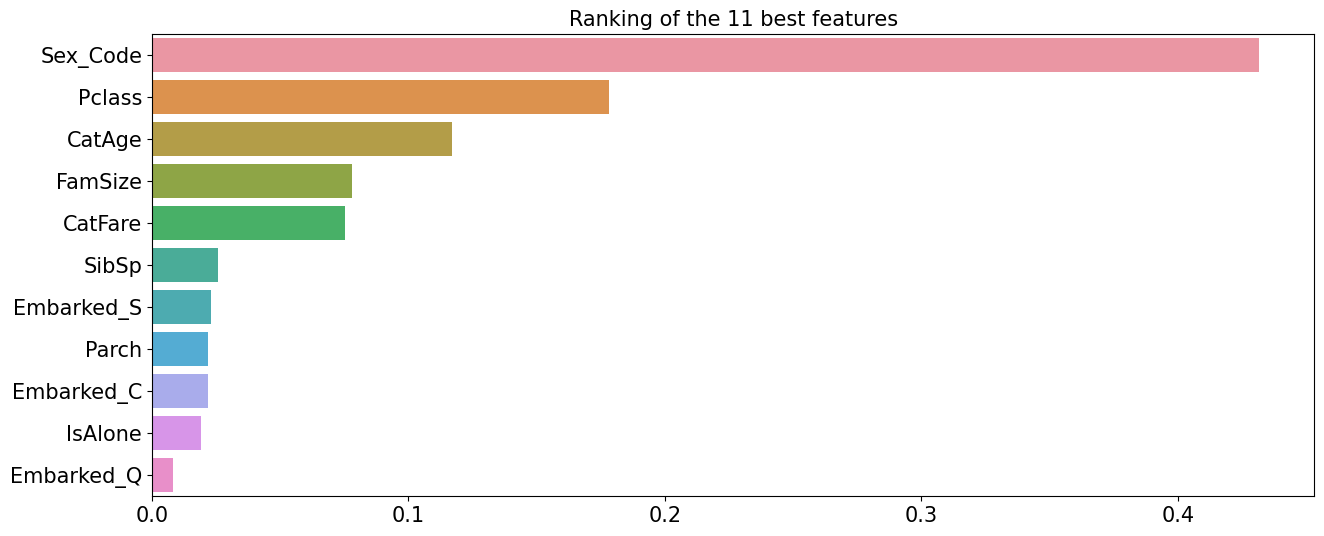

In [31]:
# NOTE: If you run this cell, you will find that the feature importance ranking of other variables has changed 
# slightly after adding our duplicate feature, despite it not appearing in a single split! This is actually because 
# since X and X_with_dup are different datasets, the model fit with both have a different random_state RNG. 
# Therefore, tied features splits may be such that model fitted with X chooses Feature A in the split, 
# and model fitted with X_with_dup chooses Feature B in the tied split. You can check your model stability by 
# comparing the predictions of several DecisionTrees with different random states.

model.fit(X, y)
plot_feature_importances(X.columns, model.feature_importances_)

It's trivial that a duplicate feature with no extra information should not be included in our model, we don't need RFECV for that. It gets more complicated when dealing with highly correlated features. First let us define a metric in order for us to measure how correlated two features are. There are multiple choices, but the easiest to implement and the most suitable one for our dataset is the Pearson correlation coefficient.

**Pearson Correlation Heatmap**

Let us generate some correlation plots of the features to see how related one feature is to the next. To do so, we will utilise the Seaborn plotting package which allows us to plot heatmaps very conveniently as follows:


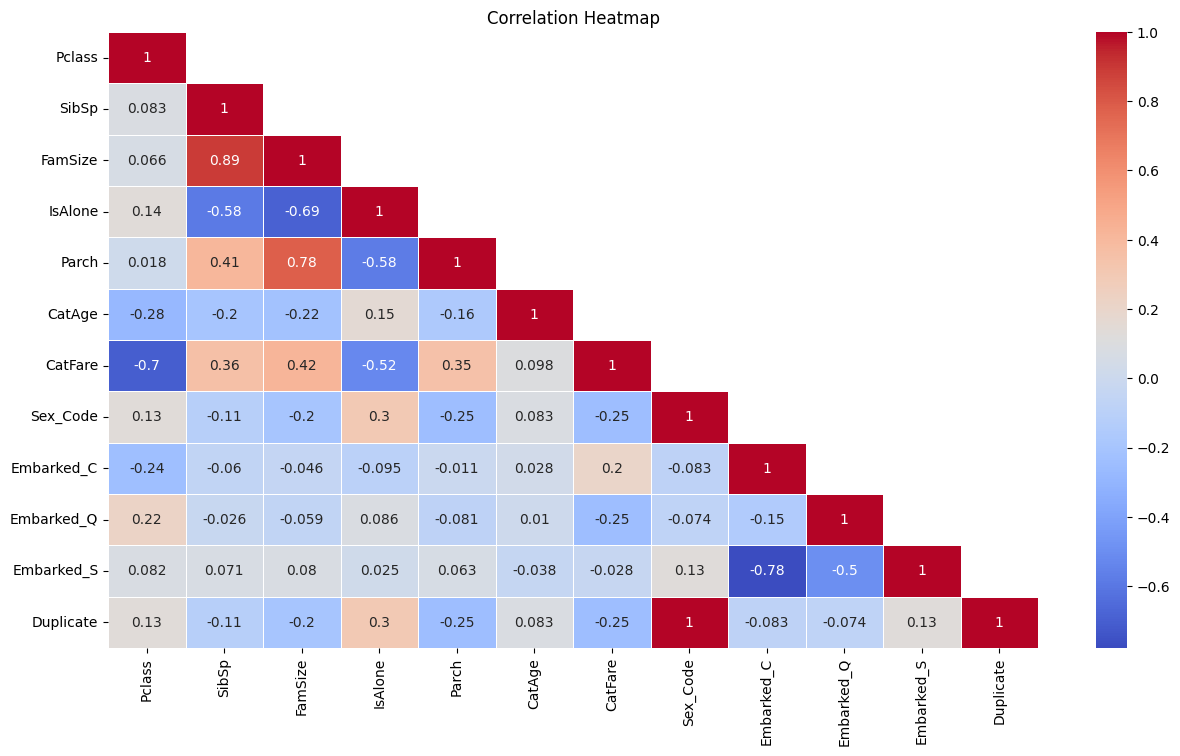

In [32]:
def plot_corr_map(data):    
    corr_matrix = data.corr()
    mask = np.zeros_like(corr_matrix)
    mask[np.triu_indices_from(mask, k=1)] = True

    plt.figure(figsize=(15, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', mask=mask, linewidths=.5)
    plt.title("Correlation Heatmap")
    plt.show()
    
plot_corr_map(X_with_dup)

**Takeaway from the Plots**

It is not immediately clear how high the degree of correlation must be in order for a feature to start becoming redundant. Having low correlation is good from a point of view of feeding these features into your learning model because this means that there isn't much redundant or superfluous data in our training set and we are happy that each feature carries with it some unique information. 

---

Let us engineer a new feature that contains duplicate values of another feature in some entries, but is complete noise in the rest. The following graphs will show you that this function is an excellent way to manipulate the correlation between features, and therefore strengthen our analysis of the relationship between feature correlation and feature importance.

In [33]:
def create_highly_correlated_column(existing_column, correlation_coefficient, seed=0):
    """Create a highly correlated feature with an existing feature of equal cardinality."""
    
    np.random.seed(seed)
    noisy_column = existing_column.copy()
    noise_values = noisy_column.value_counts(normalize=True).index
    distribution = noisy_column.value_counts(normalize=True).tolist()
    noisy_column = noisy_column.apply(lambda x: np.random.choice(noise_values, p=distribution) 
                                      if np.random.rand() >= correlation_coefficient else x)

    return noisy_column


X_with_dup = X.copy()
X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup["Sex_Code"], 0.5)
X_with_dup

,Pclass,SibSp,FamSize,IsAlone,Parch,CatAge,CatFare,Sex_Code,Embarked_C,Embarked_Q,Embarked_S,Noise
0,3,1,2,0,0,1,0,1,0,0,1,0
1,1,1,2,0,0,2,4,0,1,0,0,1
2,3,0,1,1,0,2,1,0,0,0,1,0
3,1,1,2,0,0,2,4,0,0,0,1,1
4,3,0,1,1,0,2,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,1,1,0,2,2,1,0,0,1,0
887,1,0,1,1,0,1,3,0,0,0,1,0
888,3,1,4,0,2,2,3,0,0,0,1,1
889,1,0,1,1,0,2,3,1,1,0,0,1


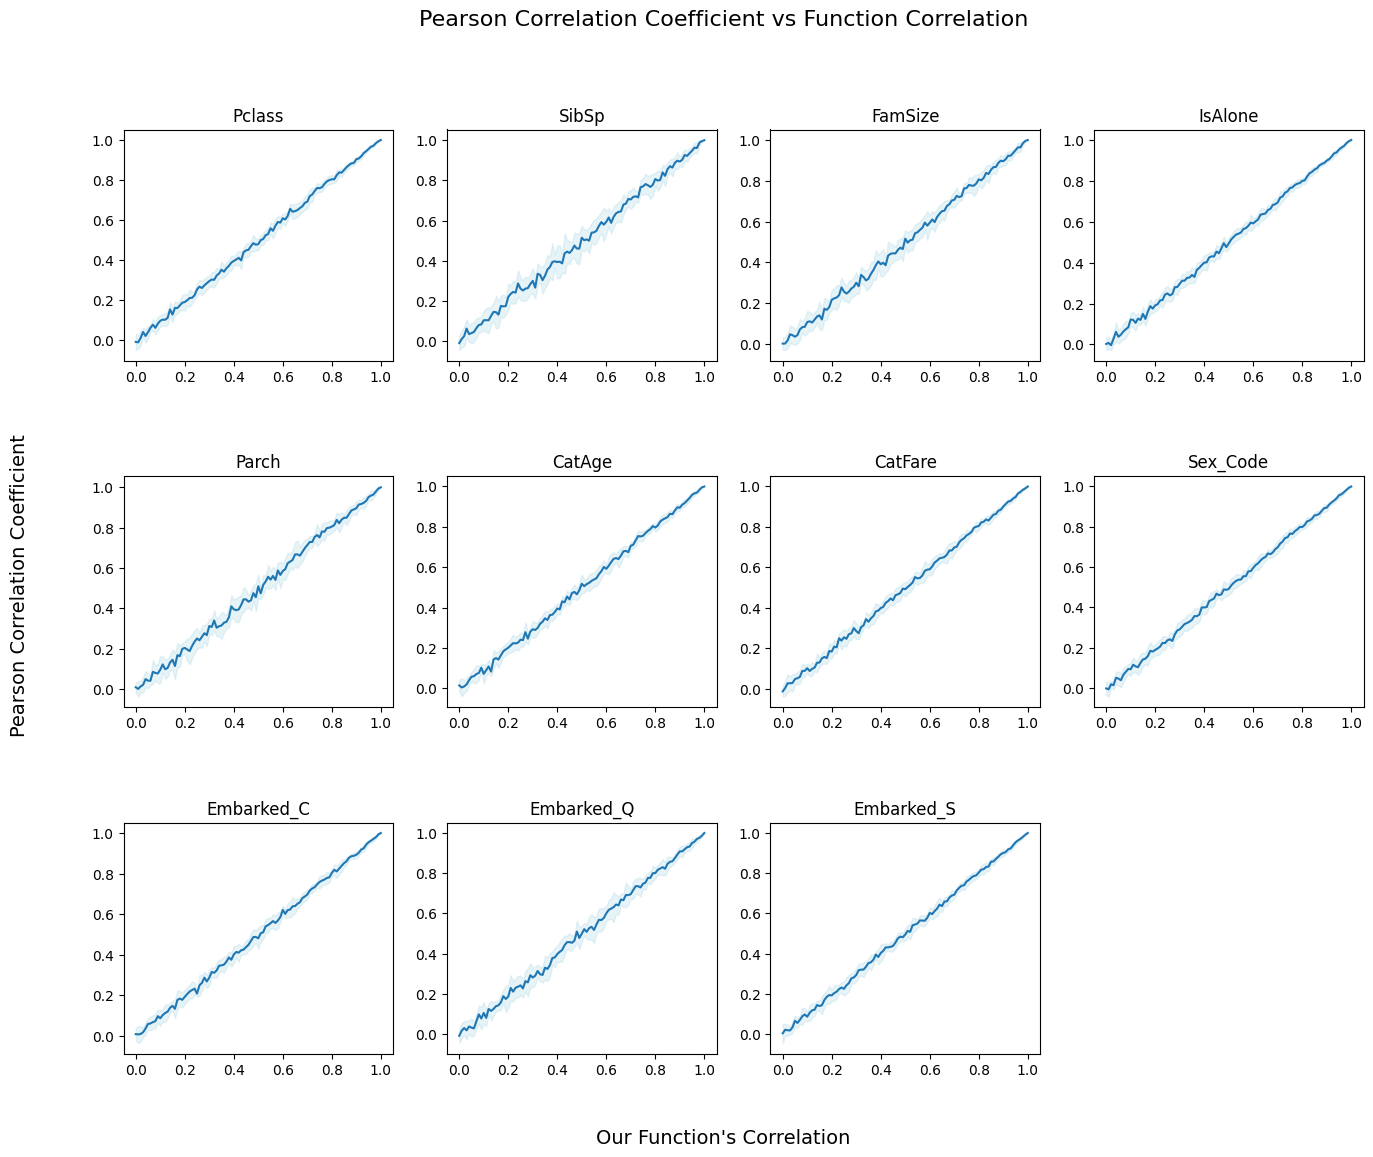

In [34]:
num_seeds = 10
num_cols = 4
num_rows = int(np.ceil(len(X.columns) / num_cols))


def plot_correlation_vs_correlation(X, y, copy_feature, num_seeds, mesh=101, ax=plt):
    X_with_dup = X.copy()
    x = np.linspace(0, 1, mesh)
    average_correlation = []

    for seed in range(num_seeds):
        correlation_coeffs = []
        for corr in x:
            X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup[copy_feature], corr, seed=seed)
            correlation_coeffs.append(X_with_dup.corr()[copy_feature]["Noise"])

        average_correlation.append(correlation_coeffs)

    # Convert the list of lists into a NumPy array for easier manipulation
    average_correlation = np.array(average_correlation)

    # Calculate the mean and standard deviation across seeds for each cardinality
    mean_correlation = np.mean(average_correlation, axis=0)
    std_correlation = np.std(average_correlation, axis=0)

    ax.plot(x, mean_correlation)
    ax.fill_between(x, 
                    mean_correlation - std_correlation, 
                    mean_correlation + std_correlation, 
                    alpha=0.3, 
                    color="lightblue")

    
# Organise these plots into subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5)

for i, var in enumerate(X.columns):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]
    
    plot_correlation_vs_correlation(X, y, var, num_seeds=num_seeds, ax=ax)
    ax.set_title(f'{var}')

# Remove empty subplots
for i in range(len(X.columns), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

fig.suptitle("Pearson Correlation Coefficient vs Function Correlation", fontsize=16)
fig.text(0.5, 0.04, "Our Function's Correlation Parameter", ha="center", va="center", fontsize=14)
fig.text(0.06, 0.5, "Pearson Correlation Coefficient", ha="center", va="center", rotation="vertical", fontsize=14)

plt.show()

The results show that our function is a very good way to manipulate the Pearson correlation coefficient between two features. Now we can introduce this variable into our dataset to simulate how the feature importances of features differ if they are correlated, compared to if they are uncorrelated.

*Note: These have been averaged over multiple RNG seeds to account for the random tie breaker outcomes in Decision Tree models, as well as the random nature of our constructed noise correlation feature.*

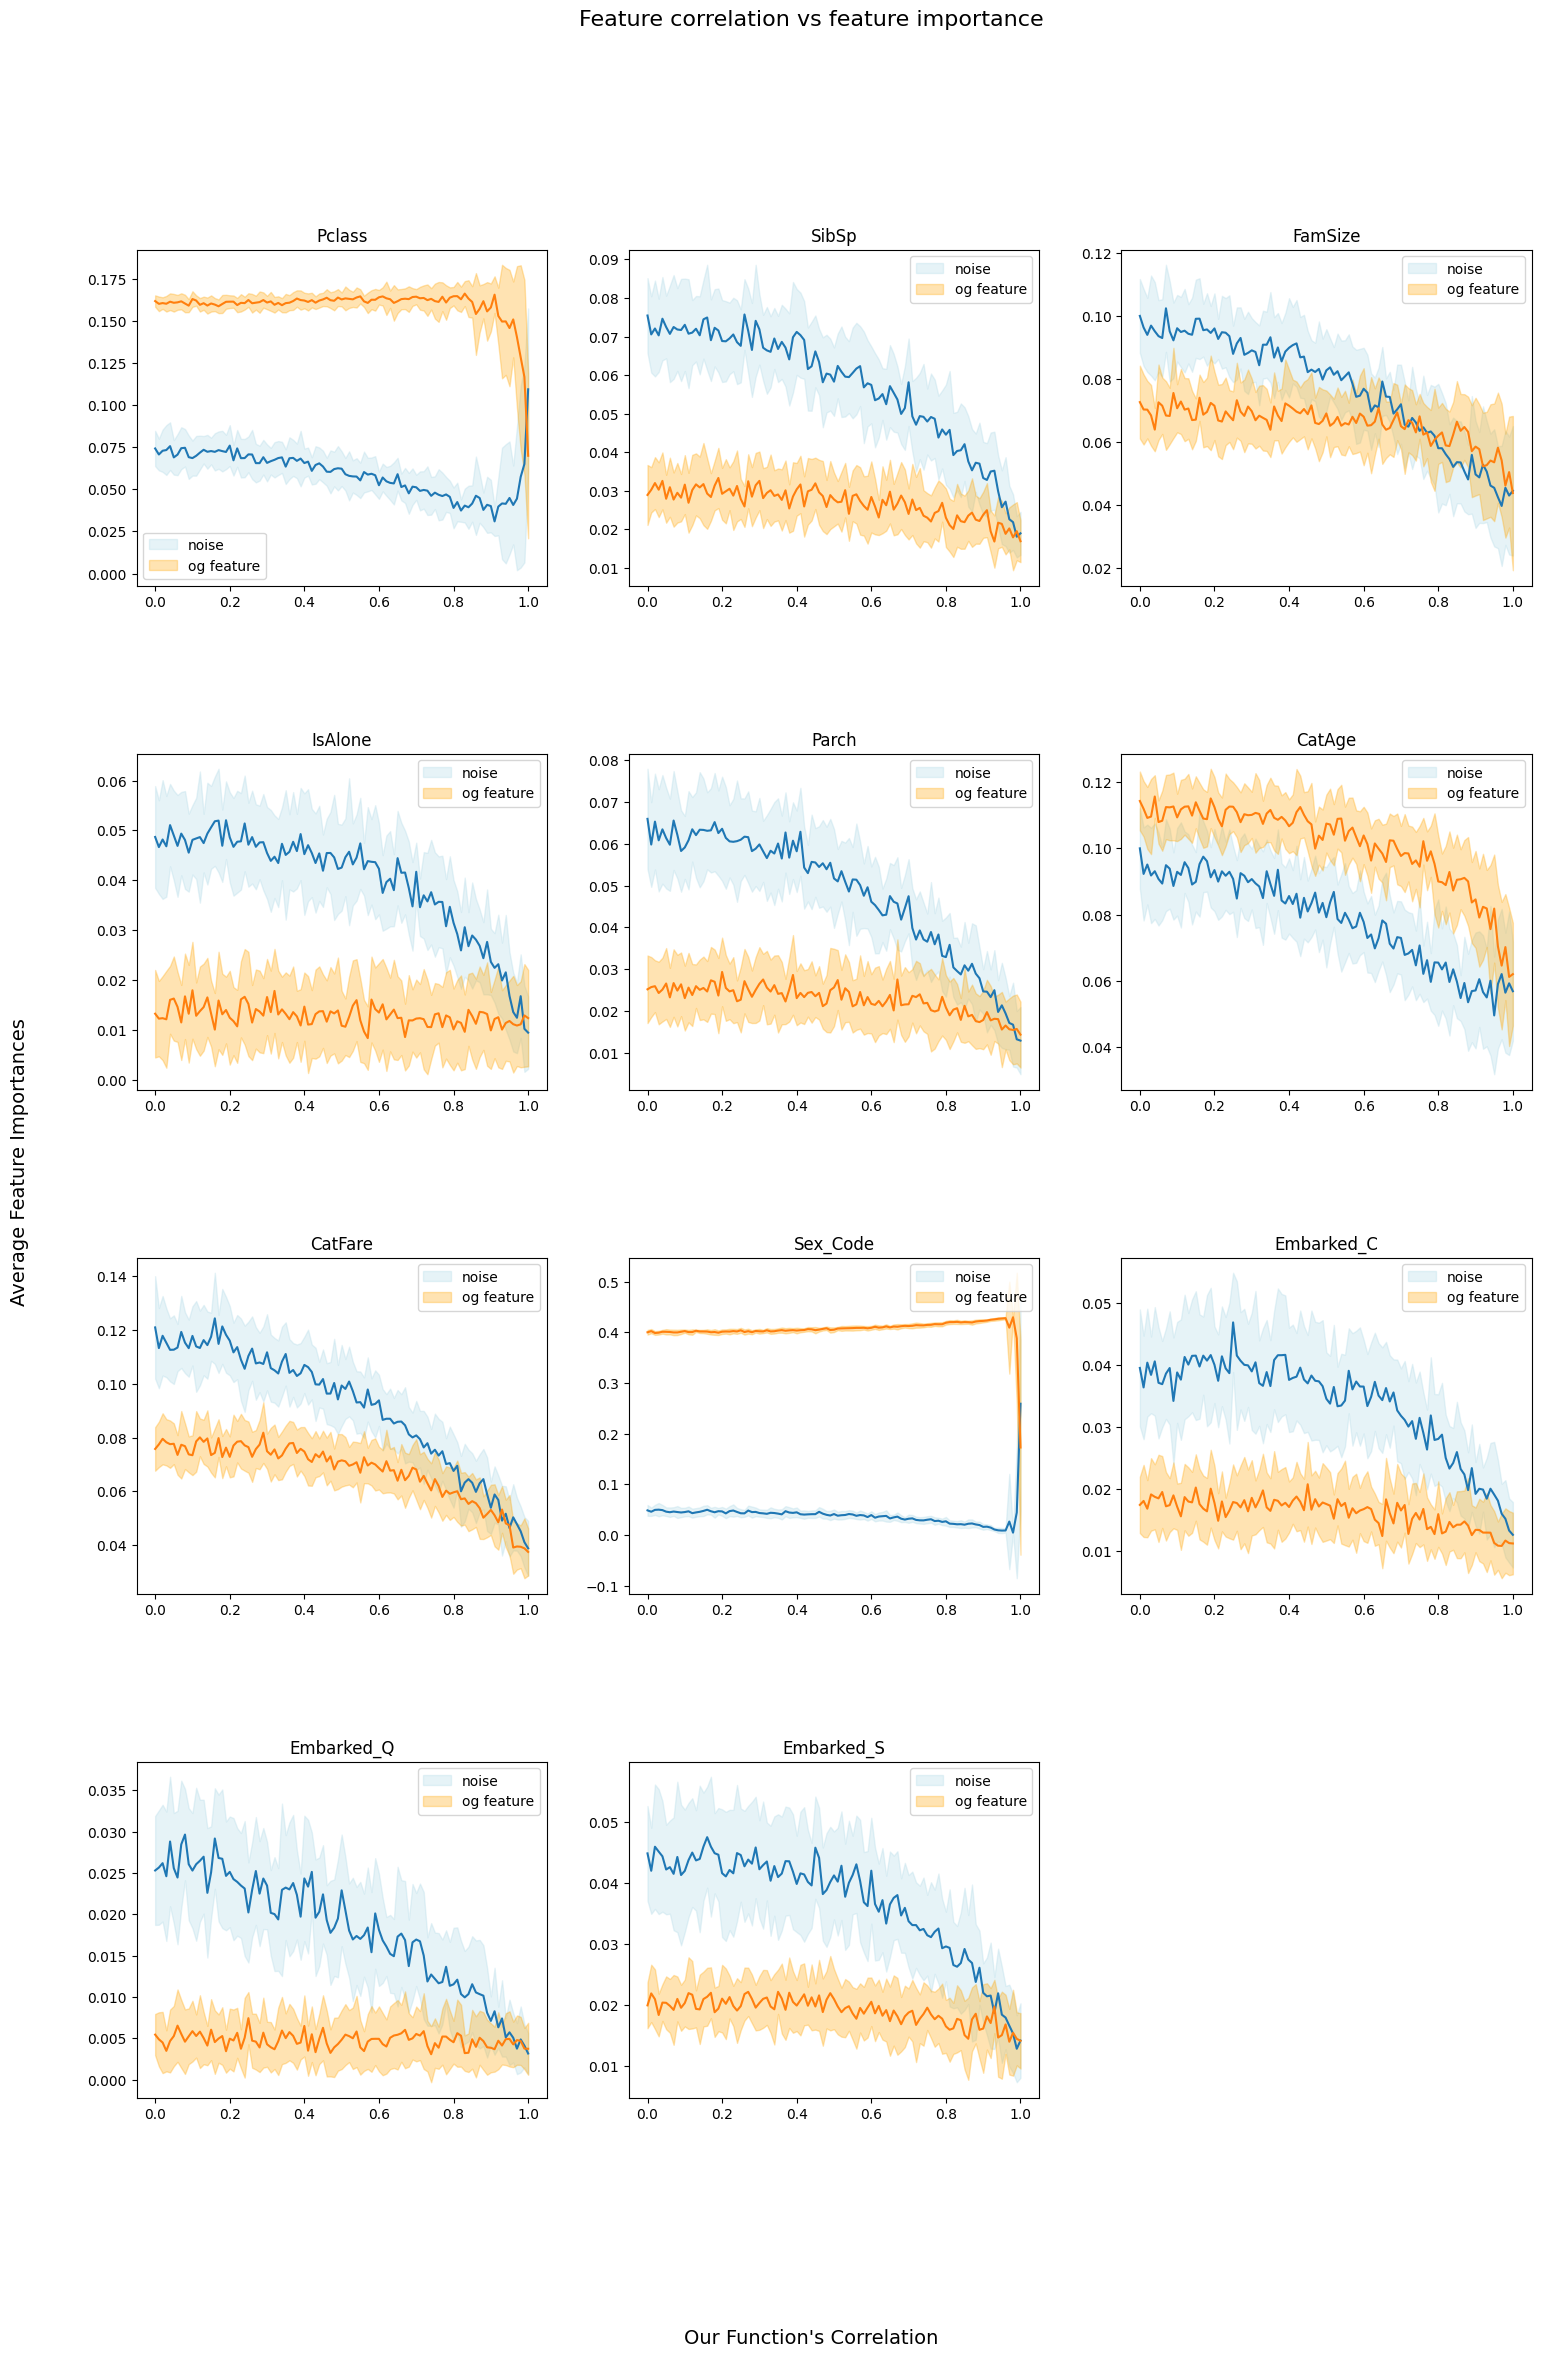

In [36]:
num_seeds = 20
num_cols = 3
num_rows = int(np.ceil(len(X.columns) / num_cols))


def plot_correlation_vs_importances(X, y, copy_feature, num_seeds=num_seeds, ax=plt):
    x = np.linspace(0, 1, 101)
    X_with_dup = X.copy()
    average_importances = []
    average_importances2 = []

    for seed in range(num_seeds):
        correlated_noise_importances = []
        correlated_noise_importances2 = []
        model = DecisionTreeClassifier(random_state=seed)
        for corr in x:
            X_with_dup["Noise"] = create_highly_correlated_column(X_with_dup[copy_feature], corr, seed=seed)
            model.fit(X_with_dup, y)
            correlated_noise_importances.append(model.feature_importances_[X_with_dup.columns.get_loc("Noise")])
            correlated_noise_importances2.append(model.feature_importances_[X_with_dup.columns.get_loc(copy_feature)])
        average_importances.append(correlated_noise_importances)
        average_importances2.append(correlated_noise_importances2)

    # Convert the list of lists into a NumPy array for easier manipulation
    average_importances = np.array(average_importances)
    average_importances2 = np.array(average_importances2)

    # Calculate the mean and standard deviation across seeds for each cardinality
    mean_importances = np.mean(average_importances, axis=0)
    std_importances = np.std(average_importances, axis=0)

    mean_importances2 = np.mean(average_importances2, axis=0)
    std_importances2 = np.std(average_importances2, axis=0)

    # Plot the mean with error bars representing the standard deviation
    x = np.linspace(0, 1, 101)
    ax.plot(x, mean_importances)
    ax.fill_between(x, 
                    mean_importances - std_importances, 
                    mean_importances + std_importances, 
                    alpha=0.3, 
                    color="lightblue",
                    label="noise")
    
    ax.plot(x, mean_importances2)
    ax.fill_between(x, 
                    mean_importances2 - std_importances2, 
                    mean_importances2 + std_importances2, 
                    alpha=0.3, 
                    color="orange",
                    label="og feature")

    
# Organise these plots into subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 24))
fig.subplots_adjust(hspace=0.5)

for i, var in enumerate(X.columns):
    row, col = divmod(i, num_cols)
    ax = axes[row, col]
    
    plot_correlation_vs_importances(X, y, copy_feature=var, num_seeds=num_seeds, ax=ax)
    ax.set_title(f'{var}')
    ax.legend()

# Remove empty subplots
for i in range(len(X.columns), num_cols * num_rows):
    fig.delaxes(axes.flatten()[i])

fig.suptitle("Feature correlation vs feature importance", fontsize=16)
fig.text(0.5, 0.01, "Our Function's Correlation", ha="center", va="center", fontsize=14)
fig.text(0.06, 0.5, "Average Feature Importances", ha="center", va="center", rotation="vertical", fontsize=14)

plt.show()

We can make two major observations:

</br>

1. Two features can be highly correlated, but have very different feature importance (Sex_Code, Pclass). The feature importances do begin to equalize as the correlation tends to 1, but depending on the variables (cardinality, number of splits, etc.), even variables with 0.9 correlation coefficient could have drastic differences in feature importances.

    From this we can see that **RFECV does not necessarily remove correlated features**. It may remove one if the importance of a correlated feature is low and doesn't increase the accuracy of our model (such as our Duplicate example above) but it may also keep both if they are both substantially important and contribute to model performance.

</br>

2. Each variable has some degree of correlation value for which the correlated variable begins to "steal" the feature importance from the original variable. This is why each orange line begins to decrease continuously to half its original value when the correlated value is an exact duplicate. For CatFare and CatAge this decrease can be seen fairly on.

    This observation is perfectly explained by a [**datadive blog on tree based feature selection**](http://blog.datadive.net/selecting-good-features-part-iii-random-forests/):

    > Secondly, when the dataset has two (or more) correlated features, then from the point of view of the model, any of these correlated features can be used as the predictor, with no concrete preference of one over the others. But once one of them is used, the importance of others is significantly reduced since effectively the impurity they can remove is already removed by the first feature. As a consequence, they will have a lower reported importance. This is not an issue when we want to use feature selection to reduce overfitting, since it makes sense to remove features that are mostly duplicated by other features. But when interpreting the data, it can lead to the incorrect conclusion that one of the variables is a strong predictor while the others in the same group are unimportant, while actually they are very close in terms of their relationship with the response variable.

    Therefore strong features may seem to have a lower feature importance if there are other strongly correlated features that could take its place. This means if we use RFECV with a large step size such that it removes multiple features in one iteration, it may eliminate several strong features at an early stage and lead to misleading results. Many features above these correlated strong features may be redundant, but kept in the RFECV algorithm in order to keep the strong lower feature importance features. This brings us to the main question. 

</br>

### *Should you remove correlated features before using RFECV?*

From the above analysis, we see that the technique can select highly correlated variables too. So if your base model can handle correlated features, then RFECV itself will likely not present any problems either. You should also be careful to pick a suitable RFECV step size for your dataset in order to use the technique efficiently.

If your model requires less degree of multicolliniearity in the data, consider applying another dimensionality reduction technique such as PCA before using RFECV. PCA removes the highly correlated features from the dataset and makes RFECV more reliable as a second feature selection layer.